In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

import astropy.units as u

from joblib import Parallel, delayed

In [21]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [13]:
GFM_SOLAR_METALLICITY = 0.0127

GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_HELIUM  =  (1.-GFM_SOLAR_ABUNDANCE_HYDROGEN -GFM_SOLAR_METALLICITY)
GFM_SOLAR_ABUNDANCE_CARBON  =  0.0024
GFM_SOLAR_ABUNDANCE_NITROGEN =  0.0007
GFM_SOLAR_ABUNDANCE_OXYGEN  =  0.0057
GFM_SOLAR_ABUNDANCE_NEON    =  0.0012
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_SILICON =  0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
GFM_SOLAR_ABUNDANCE_OTHER  =   0

HUBBLE = 3.2407789e-18
SEC_PER_MEGAYEAR = 3.15576e13

In [3]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [7]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [8]:
def get_rot_pos_vel(snap, subhalo, ptype=4, rhalf_fac=2, phys=True):
    # get COM, COMV, and ang mom of stars
    COM = subhalo['SubhaloPos']
    pos = snap[4]['Coordinates'] - COM
    r = np.linalg.norm(pos, axis=1)
    
    rhalf = subhalo['SubhaloHalfmassRadType'][4]
    print(rhalf)

    in_rhalf = r < 2 * rhalf
    is_star = snap[4]['GFM_StellarFormationTime'] > 0
    is_star_in_rhalf = np.logical_and(is_star, in_rhalf)
    
    vel_in_rhalf = snap[4]['Velocities'][is_star_in_rhalf]
    mass_in_rhalf = snap[4]['Masses'][is_star_in_rhalf]
    COMV = np.average(vel_in_rhalf, axis=0, weights=mass_in_rhalf)
    print(COMV)
    
    vel = snap[4]['Velocities'] - COMV
    
    ang = np.cross(pos[is_star_in_rhalf], vel[is_star_in_rhalf])
    ang *= mass_in_rhalf.reshape(-1, 1)
    ang = np.sum(ang, axis=0)
    
    ang_mom = ang

    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    print(angmom_dir)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)

    pos = snap[ptype]['Coordinates'] - COM
    vel = snap[ptype]['Velocities'] - COMV
    mass = snap[ptype]['Masses']
    
    pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
    vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)
    
    return pos_rot, vel_rot, mass

In [11]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [9]:
subID = 523889

subhalo = il.groupcat.loadSingle(TNGbase, 99, subhaloID=subID)

In [10]:
snap = {}
snap[4] = il.snapshot.loadSubhalo(TNGbase, 99, subID, 4)

In [16]:
pos, vel, mass = get_rot_pos_vel(snap, subhalo, rhalf_fac=1)

pos *= meta['header'][99].Time/meta['header'][99].HubbleParam
vel *= np.sqrt(meta['header'][99].Time)

R = np.linalg.norm(pos[:,:2], axis=1)
in_SN = np.logical_and(np.logical_and(R > 6, R < 10), np.abs(pos[:,2]) < 3)

is_star = snap[4]['GFM_StellarFormationTime'] > 0
is_star_in_SN = np.logical_and(is_star, in_SN)

Z = snap[4]['GFM_Metallicity'] / GFM_SOLAR_METALLICITY
logZ = np.log10(Z)

FeH = snap[4]['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
logFeH = np.log10(FeH)

MgH = snap[4]['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
MgFe = MgH/FeH
logMgFe = np.log10(MgFe)

a_born = snap[4]['GFM_StellarFormationTime']
t_born = get_time(a_born)

3.4344184
[-198.0273  -127.60852  -84.05695]
[ 0.36309068 -0.72906581  0.58019669]


In [17]:
t0 = meta['time'][48]-0.1
t1 = meta['time'][48]+0.1
high_time = np.logical_and(t_born > t0, t_born < t1)
high_Fe = np.logical_and(logFeH > -0.25, logFeH < 0.0)
key_high = np.logical_and(np.logical_and(is_star_in_SN, high_time), high_Fe)

t0 = meta['time'][50]-0.1
t1 = meta['time'][50]+0.1
low_time = np.logical_and(t_born > t0, t_born < t1)
low_Fe = np.logical_and(logFeH > -1, logFeH < -0.5)
key_low = np.logical_and(np.logical_and(is_star_in_SN, low_time), low_Fe)

print(len(np.where(key_high)[0]))
print(len(np.where(key_low)[0]))

532
576


In [32]:
t = h5.File(basepath+'anlysTNG/tracer/subhalo'+str(subID)+'/props_subhalo'+str(subID)+'.h5', mode='r')

In [33]:
ParticleIDs_h = snap[4]['ParticleIDs'][key_high]
ParticleIDs_l = snap[4]['ParticleIDs'][key_low]

key_h = np.argwhere(np.isin(t['ParticleIDs'][99,:], ParticleIDs_h)).ravel()
key_l = np.argwhere(np.isin(t['ParticleIDs'][99,:], ParticleIDs_l)).ravel()

In [55]:
print(meta['time'][32])
print(meta['time'][32] - meta['time'][25])

3.1289319094911066
0.9835488991780372


In [45]:
treeMPB = il.sublink.loadTree(TNGbase, 99, subID, onlyMPB=True)

In [73]:
pos = treeMPB['GroupPos'][treeMPB['SnapNum'] == 25]
tracer_pos_h = t['Coordinates'][25,key_h] - pos
tracer_h = np.linalg.norm(tracer_pos_h, axis=1)

tracer_pos_l = t['Coordinates'][25,key_l] - pos
tracer_l = np.linalg.norm(tracer_pos_l, axis=1)

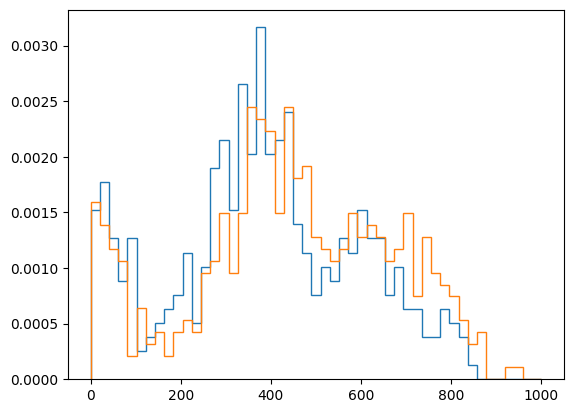

In [74]:
plt.hist(tracer_r, bins=np.linspace(0, 1000, 50), histtype='step', density=True);
plt.hist(tracer_l, bins=np.linspace(0, 1000, 50), histtype='step', density=True);

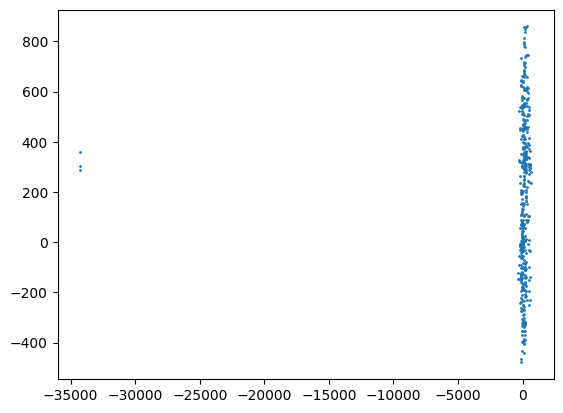

In [72]:
plt.scatter(tracer_pos_l[:,0], tracer_pos_l[:,1], s=1)

In [76]:
key_l[np.argmax(tracer_l)]

184892

In [77]:
t['Coordinates'][99,184892]

array([32355.05661959, 34675.55303717,  8219.15230865])

In [ ]:
np.median(t['Coordinates'][99], axis=0